![alt text](entry.png "Title")

In [1]:
from vrp_viz import VRPPlot
from ortools.constraint_solver import routing_enums_pb2, pywrapcp
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import pandas as pd
import time
import matplotlib.pyplot as plt
import random

In [2]:
app = Nominatim(user_agent="JournalDev")

In [3]:
def _prepare_data(address_list):

    df = pd.DataFrame({"lat": [],
                       "lon": []})

    for address in address_list:
        try:
            time.sleep(1)
            location = app.geocode(address).raw
            df.loc[len(df.index)] = [location['lat'], location['lon']]
        except Exception as e:
            print(e)

    return [(float(df.loc[index, 'lat']), float(df.loc[index, 'lon']))
            for index, row in df.iterrows()]

In [4]:
def _create_data_model(distances, num_vehicles=None):
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = distances
    data['num_vehicles'] = 1 if num_vehicles == None else num_vehicles
    data['depot'] = 0
    return data

In [5]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}km\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print('Maximum of the route distances: {}km'.format(max_route_distance))

In [6]:
def return_solution(data, manager, routing, solution):
    index = routing.Start(0)
    output = []
    distances = []
    total_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        single_output = []
        index = routing.Start(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            single_output.append(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
            
        single_output.append(0)
        output.append(single_output)
        distances.append(f'{int(route_distance)} km')
        total_distance += int(route_distance)
    return output, distances, total_distance

In [7]:
def perform_TSP(data, manager, routing):
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        3000000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)
    
    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Return solution or print solution on console
    if solution:
        return solution


In [8]:
def distance_between_two_nodes(start: tuple, end: tuple):
    return int(((end[1]-start[1])**2+(end[0]-start[0])**2)**(1/2))

# Zamki w Polsce

In [9]:
address_list = ['Wawel Castle in Krakow, Poland',
                'Malbork Castle, Poland',
                'Warsaw Royal Castle, Poland',
                'Książ Castle, Poland',
                'Czocha Castle, Poland',
                'Niedzica Castle, Poland']

locations = _prepare_data(address_list=address_list)
distances = [[int(geodesic(a,b).km) for a in locations]
                          for b in locations]

data = _create_data_model(distances=distances)

# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'], data['depot'])
# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)

solution = perform_TSP(data=data, manager=manager, routing=routing)

In [10]:
print_solution(data=data, manager=manager, routing=routing, solution=solution)

Route for vehicle 0:
 0 ->  5 ->  3 ->  4 ->  1 ->  2 -> 0
Distance of the route: 1388km

Maximum of the route distances: 1388km


In [11]:
locations.append(locations[0])
routes, distances, total_distance = return_solution(data=data, manager=manager, routing=routing, solution=solution)
VRPPlot(coords=locations,
        trails=routes) \
        .show()

# Europejskie stolice

In [12]:
capitals = ['Zurich',
            'Vienna',
            'Rome',
            'Prague',
            'Amsterdam',
            'Madrid',
            'Sofia, Bulgaria']

locations = _prepare_data(address_list=capitals)
distances = [[int(geodesic(a,b).km) for a in locations]
                          for b in locations]

data = _create_data_model(distances=distances)

# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'], data['depot'])
# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)

solution = perform_TSP(data=data, manager=manager, routing=routing)

In [13]:
print_solution(data=data, manager=manager, routing=routing, solution=solution)

Route for vehicle 0:
 0 ->  5 ->  2 ->  6 ->  1 ->  3 ->  4 -> 0
Distance of the route: 5906km

Maximum of the route distances: 5906km


In [14]:
locations.append(locations[0])
routes, distances, total_distance = return_solution(data=data, manager=manager, routing=routing, solution=solution)
VRPPlot(coords=locations,
        trails=routes) \
        .show()

# Randomowe punkty

In [15]:
N = 100
coords_x = random.sample(list(range(0, N)), 45)
coords_y = random.sample(list(range(0, N)), 45)

In [16]:
locations = [(coords_x[i], coords_y[i]) for i in range(len(coords_x))]
distances = [[distance_between_two_nodes(a, b) for a in locations]
                          for b in locations]
num_vehicles = 3

data = _create_data_model(distances=distances, num_vehicles=num_vehicles)

# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'], data['depot'])
# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)

solution = perform_TSP(data=data, manager=manager, routing=routing)

In [17]:
print_solution(data=data, manager=manager, routing=routing, solution=solution)

Route for vehicle 0:
 0 ->  36 ->  2 ->  39 ->  33 ->  21 ->  27 ->  12 ->  22 ->  18 ->  3 ->  43 ->  41 ->  1 ->  37 ->  40 ->  25 ->  14 ->  23 ->  10 ->  26 ->  38 -> 0
Distance of the route: 276km

Route for vehicle 1:
 0 ->  6 ->  13 ->  44 ->  15 ->  28 ->  29 ->  19 ->  31 ->  11 -> 0
Distance of the route: 199km

Route for vehicle 2:
 0 ->  34 ->  32 ->  30 ->  35 ->  9 ->  8 ->  4 ->  24 ->  42 ->  20 ->  17 ->  7 ->  16 ->  5 -> 0
Distance of the route: 276km

Maximum of the route distances: 276km


In [18]:
def return_solution(data, manager, routing, solution):
    index = routing.Start(0)
    output = []
    distances = []
    total_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        single_output = []
        index = routing.Start(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            single_output.append(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
            
        single_output.append(0)
        output.append(single_output)
        distances.append(f'{int(route_distance)} km')
        total_distance += int(route_distance)
    return output, distances, total_distance

In [19]:
routes, distances, total_distance = return_solution(data=data, manager=manager, routing=routing, solution=solution)

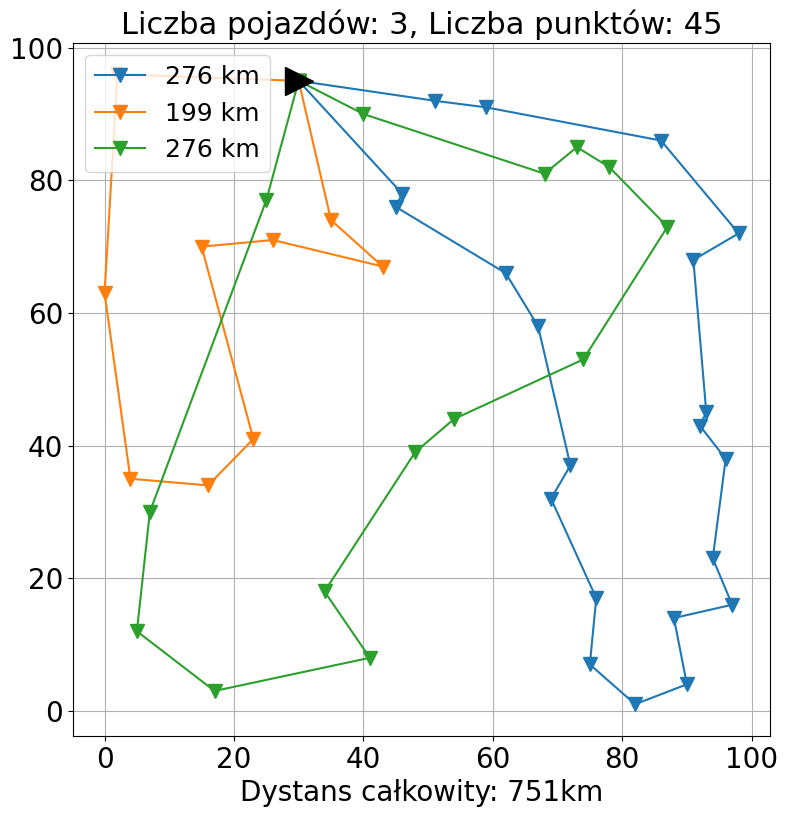

In [20]:
plt.figure(figsize=(9, 9))
for route in routes:
    coords_route_x = [coords_x[node] for node in route]
    coords_route_y = [coords_y[node] for node in route]
    plt.plot(coords_route_x, coords_route_y, 'v-', markersize=10)
plt.plot(coords_x[0], coords_y[0], '>', color='black', markersize=20)
plt.legend(distances, prop={'size': 18})
plt.title(f'Liczba pojazdów: {num_vehicles}, Liczba punktów: {len(locations)}', fontsize=22)
plt.yticks(fontsize=20)
plt.xlabel(f'Dystans całkowity: {total_distance}km', fontsize=20)
plt.xticks(fontsize=20)
plt.grid()